# Event Camera Data Visualization with evlib

This notebook demonstrates various visualization techniques for event camera data using the `evlib` library. Event cameras (also known as Dynamic Vision Sensors or DVS) capture changes in pixel intensity rather than absolute intensity values, resulting in sparse, asynchronous data streams with high temporal resolution.

We'll demonstrate multiple ways to visualize and understand event data, including:
- Basic event visualization
- 3D spatiotemporal plots
- Event slice visualization
- Time surface representations
- Event frame accumulation
- Transformation visualizations

Let's start by importing the necessary packages:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import evlib

# Set random seed for reproducibility
np.random.seed(42)

## 1. Generating Synthetic Event Data

First, let's generate some synthetic event data to work with. We'll create patterns that mimic real event camera data:

In [2]:
def generate_moving_bar_events(width=128, height=128, num_frames=20):
    """Generate synthetic DVS events from a moving horizontal bar pattern"""
    events = []
    timestamps = np.linspace(0, 1, num_frames)
    
    # Create moving horizontal bar
    for i, t in enumerate(timestamps):
        y_pos = int(height * (i / num_frames))
        
        # Generate positive events at leading edge and negative at trailing edge
        for x in range(width):
            if i > 0 and y_pos > 0:
                events.append((x, y_pos, t, 1))  # Positive events (brightness increase)
                events.append((x, y_pos-1, t, -1))  # Negative events (brightness decrease)
    
    # Convert to numpy arrays
    xs = np.array([e[0] for e in events], dtype=np.int64)
    ys = np.array([e[1] for e in events], dtype=np.int64)
    ts = np.array([e[2] for e in events], dtype=np.float64)
    ps = np.array([e[3] for e in events], dtype=np.int64)
    
    return xs, ys, ts, ps

def generate_rotating_object_events(width=128, height=128, num_frames=30, radius=40):
    """Generate synthetic DVS events from a rotating object"""
    events = []
    timestamps = np.linspace(0, 1, num_frames)
    center_x, center_y = width // 2, height // 2
    
    # Define object points (corners of a square)
    square_points = [
        (-radius, -radius), (radius, -radius), 
        (radius, radius), (-radius, radius)
    ]
    
    prev_points = None
    
    # Rotate the object
    for i, t in enumerate(timestamps):
        angle = 2 * np.pi * (i / num_frames)
        cos_a, sin_a = np.cos(angle), np.sin(angle)
        
        # Rotate points
        rotated_points = []
        for px, py in square_points:
            rx = int(px * cos_a - py * sin_a + center_x)
            ry = int(px * sin_a + py * cos_a + center_y)
            rotated_points.append((rx, ry))
        
        # Connect points to form lines
        if prev_points is not None:
            for j, (curr_p, prev_p) in enumerate(zip(rotated_points, prev_points)):
                # Interpolate points along the line
                steps = max(abs(curr_p[0] - prev_p[0]), abs(curr_p[1] - prev_p[1]))
                steps = max(steps, 1)
                
                for step in range(steps):
                    alpha = step / steps
                    x = int((1 - alpha) * prev_p[0] + alpha * curr_p[0])
                    y = int((1 - alpha) * prev_p[1] + alpha * curr_p[1])
                    
                    if 0 <= x < width and 0 <= y < height:
                        events.append((x, y, t, 1))  # Positive at current position
                        events.append((prev_p[0], prev_p[1], t, -1))  # Negative at previous
        
        # Draw lines between current points to form shape
        for j in range(len(rotated_points)):
            p1 = rotated_points[j]
            p2 = rotated_points[(j + 1) % len(rotated_points)]
            
            # Interpolate points along the line
            steps = max(abs(p2[0] - p1[0]), abs(p2[1] - p1[1]))
            steps = max(steps, 1)
            
            for step in range(steps):
                alpha = step / steps
                x = int((1 - alpha) * p1[0] + alpha * p2[0])
                y = int((1 - alpha) * p1[1] + alpha * p2[1])
                
                if 0 <= x < width and 0 <= y < height:
                    events.append((x, y, t, 1))
        
        prev_points = rotated_points
    
    # Convert to numpy arrays and sort by timestamp
    events_array = np.array(events, dtype=[('x', np.int64), ('y', np.int64), 
                                         ('t', np.float64), ('p', np.int64)])
    events_array.sort(order='t')
    
    xs = events_array['x']
    ys = events_array['y']
    ts = events_array['t']
    ps = events_array['p']
    
    return xs, ys, ts, ps

# Generate two different event patterns
width, height = 128, 128
print("Generating event data...")

bar_xs, bar_ys, bar_ts, bar_ps = generate_moving_bar_events(width, height)
print(f"Generated {len(bar_xs)} events for moving bar pattern")

rot_xs, rot_ys, rot_ts, rot_ps = generate_rotating_object_events(width, height)
print(f"Generated {len(rot_xs)} events for rotating object pattern")

Generating event data...
Generated 4864 events for moving bar pattern
Generated 11082 events for rotating object pattern


## 2. Basic 2D Event Visualization

Let's start with a basic visualization showing events in 2D space, color-coded by polarity:

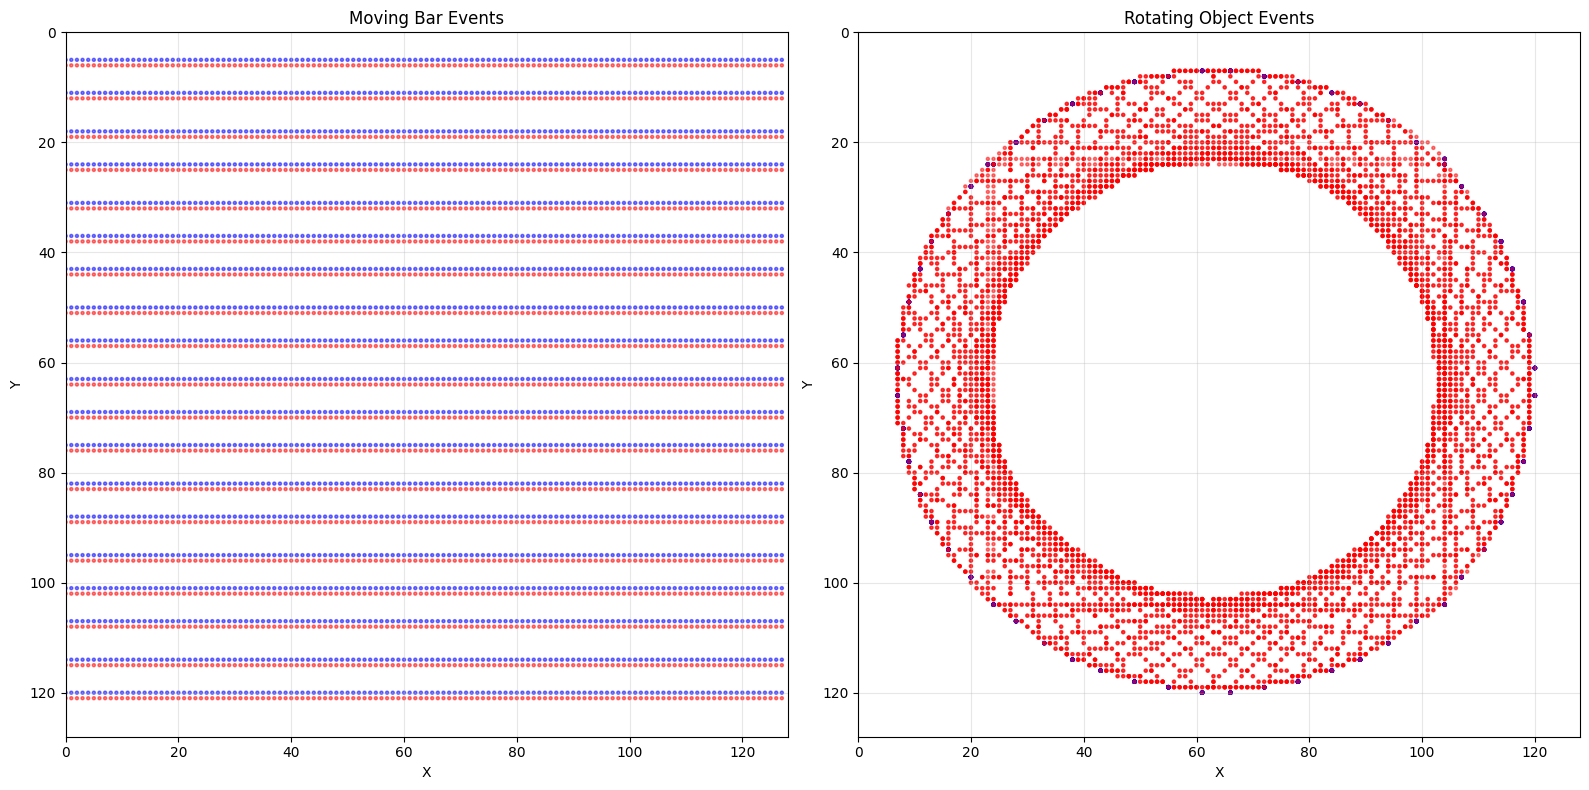

In [3]:
def plot_events_2d(xs, ys, ps, title="Events", ax=None):
    """Plot events in 2D with color representing polarity"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
        
    # Color by polarity (red=positive, blue=negative)
    colors = ['r' if p > 0 else 'b' for p in ps]
    
    ax.scatter(xs, ys, c=colors, s=5, alpha=0.5)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_xlim(0, width)
    ax.set_ylim(0, height)
    ax.invert_yaxis()  # Invert Y axis to match image coordinates
    ax.grid(True, alpha=0.3)
    
    return ax

# Plot 2D event data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

plot_events_2d(bar_xs, bar_ys, bar_ps, "Moving Bar Events", ax1)
plot_events_2d(rot_xs, rot_ys, rot_ps, "Rotating Object Events", ax2)

plt.tight_layout()
plt.show()

## 3. 3D Spatiotemporal Event Visualization

One of the most effective ways to visualize event data is in 3D space, with time as the third dimension:

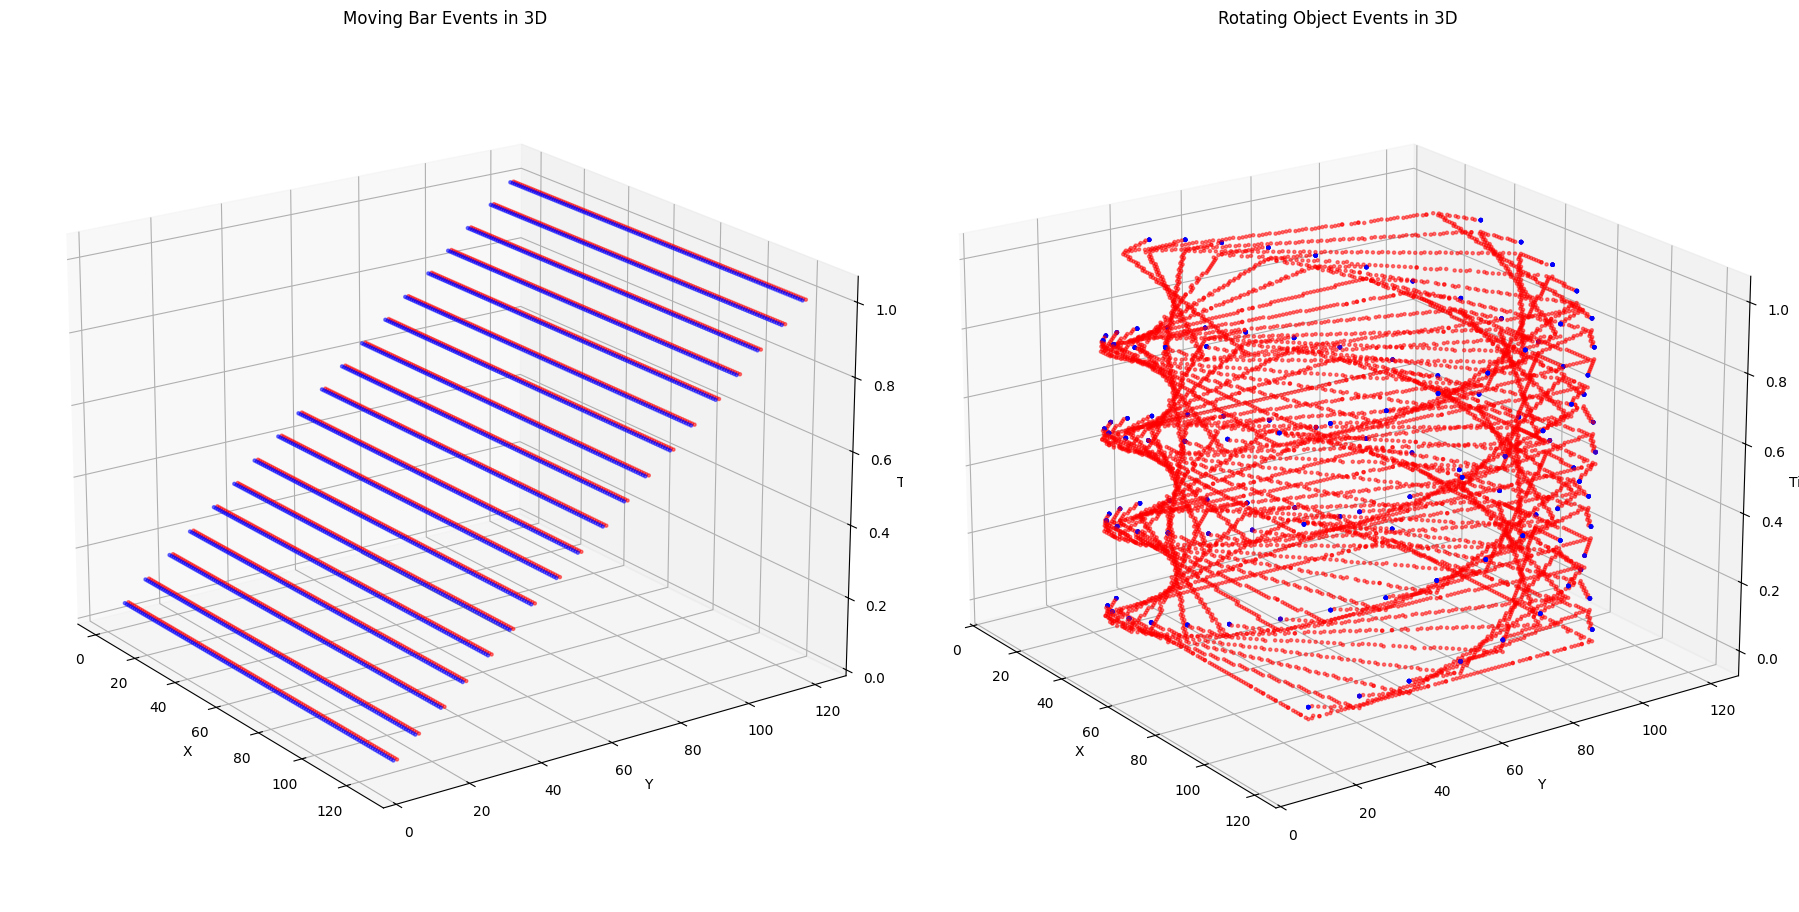

In [4]:
def plot_events_3d(xs, ys, ts, ps, title="Events", ax=None, azim=-35, elev=20):
    """Plot events in 3D space with time as the third dimension"""
    if ax is None:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
    
    # Color by polarity
    colors = ['r' if p > 0 else 'b' for p in ps]
    
    # Plot 3D points
    ax.scatter(xs, ys, ts, c=colors, s=5, alpha=0.5)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Time')
    ax.set_title(title)
    
    # Set view angle
    ax.view_init(elev=elev, azim=azim)
    
    return ax

# Plot 3D event data
fig = plt.figure(figsize=(18, 9))

ax1 = fig.add_subplot(121, projection='3d')
plot_events_3d(bar_xs, bar_ys, bar_ts, bar_ps, "Moving Bar Events in 3D", ax1)

ax2 = fig.add_subplot(122, projection='3d')
plot_events_3d(rot_xs, rot_ys, rot_ts, rot_ps, "Rotating Object Events in 3D", ax2)

plt.tight_layout()
plt.show()

## 4. Time Surface Representation

Let's create a time surface representation, which assigns a color or intensity value to each pixel based on the most recent event at that location:

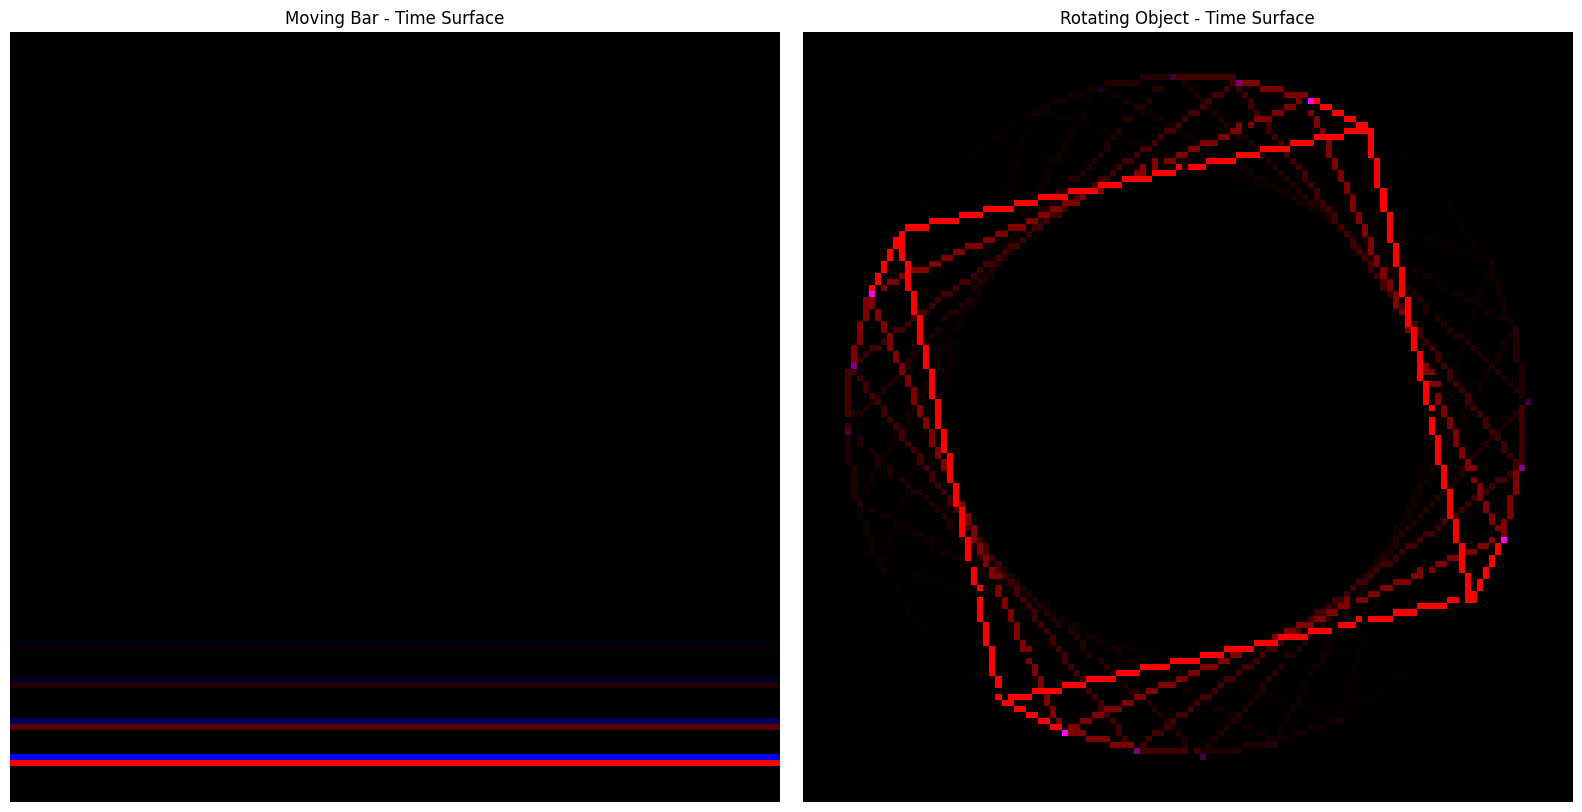

In [5]:
def create_time_surface(xs, ys, ts, ps, width, height, decay=0.05):
    """Create a time surface from events"""
    # Initialize time surfaces
    time_surface_pos = np.zeros((height, width))
    time_surface_neg = np.zeros((height, width))
    
    # Get latest timestamp
    latest_t = ts.max()
    
    # Process events
    for x, y, t, p in zip(xs, ys, ts, ps):
        if 0 <= x < width and 0 <= y < height:
            if p > 0:
                time_surface_pos[y, x] = np.exp(-(latest_t - t) / decay)
            else:
                time_surface_neg[y, x] = np.exp(-(latest_t - t) / decay)
    
    # Create RGB image: R=positive events, B=negative events
    time_surface_rgb = np.zeros((height, width, 3))
    time_surface_rgb[:, :, 0] = time_surface_pos  # Red channel for positive events
    time_surface_rgb[:, :, 2] = time_surface_neg  # Blue channel for negative events
    
    return time_surface_rgb

# Create and display time surfaces
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Moving bar time surface
ts_bar = create_time_surface(bar_xs, bar_ys, bar_ts, bar_ps, width, height)
ax1.imshow(ts_bar)
ax1.set_title("Moving Bar - Time Surface")
ax1.axis('off')

# Rotating object time surface
ts_rot = create_time_surface(rot_xs, rot_ys, rot_ts, rot_ps, width, height)
ax2.imshow(ts_rot)
ax2.set_title("Rotating Object - Time Surface")
ax2.axis('off')

plt.tight_layout()
plt.show()

## 5. Event Slice Visualization

Let's visualize events in temporal slices, to understand how they evolve over time:

Moving Bar - Event Slices:


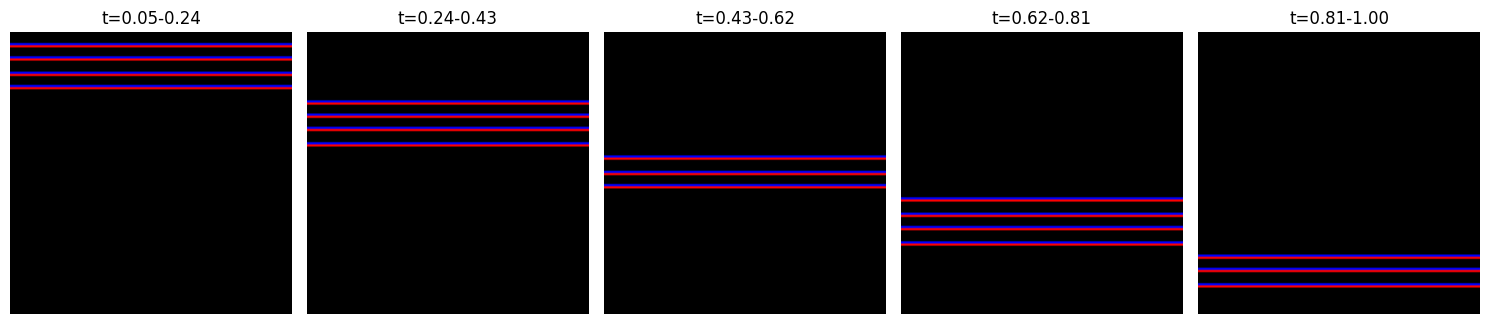

Rotating Object - Event Slices:


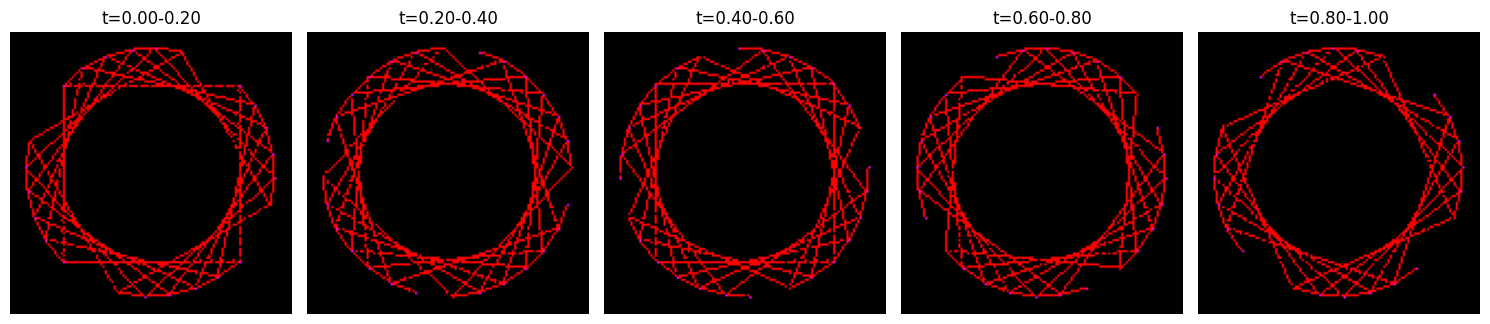

In [6]:
def visualize_event_slices(xs, ys, ts, ps, width, height, num_slices=5):
    """Visualize events in temporal slices"""
    fig, axes = plt.subplots(1, num_slices, figsize=(15, 4))
    
    # Create time bins
    t_min, t_max = ts.min(), ts.max()
    time_bins = np.linspace(t_min, t_max, num_slices+1)
    
    for i in range(num_slices):
        t_start = time_bins[i]
        t_end = time_bins[i+1]
        
        # Filter events in this time bin
        mask = (ts >= t_start) & (ts < t_end)
        slice_xs = xs[mask]
        slice_ys = ys[mask]
        slice_ps = ps[mask]
        
        # Create event image
        event_img = np.zeros((height, width, 3))
        for x, y, p in zip(slice_xs, slice_ys, slice_ps):
            if 0 <= x < width and 0 <= y < height:
                if p > 0:
                    event_img[y, x, 0] = 1  # Red for positive
                else:
                    event_img[y, x, 2] = 1  # Blue for negative
        
        # Display image
        axes[i].imshow(event_img)
        axes[i].set_title(f"t={t_start:.2f}-{t_end:.2f}")
        axes[i].axis('off')
    
    plt.tight_layout()
    return fig

# Visualize event slices
print("Moving Bar - Event Slices:")
visualize_event_slices(bar_xs, bar_ys, bar_ts, bar_ps, width, height)
plt.show()

print("Rotating Object - Event Slices:")
visualize_event_slices(rot_xs, rot_ys, rot_ts, rot_ps, width, height)
plt.show()

## 6. Event Frame Accumulation

We can also visualize events by accumulating them over time windows, creating frame-like representations:

In [7]:
def create_event_frames(xs, ys, ts, ps, width, height, num_frames=10):
    """Create frames by accumulating events over time windows"""
    frames = []
    
    # Create time bins
    t_min, t_max = ts.min(), ts.max()
    time_bins = np.linspace(t_min, t_max, num_frames+1)
    
    for i in range(num_frames):
        t_start = time_bins[i]
        t_end = time_bins[i+1]
        
        # Filter events in this time bin
        mask = (ts >= t_start) & (ts < t_end)
        slice_xs = xs[mask]
        slice_ys = ys[mask]
        slice_ps = ps[mask]
        
        # Create event image
        event_img = np.zeros((height, width))
        for x, y, p in zip(slice_xs, slice_ys, slice_ps):
            if 0 <= x < width and 0 <= y < height:
                event_img[y, x] += p  # Accumulate polarity
        
        # Normalize for visualization
        if event_img.max() != event_img.min():
            event_img = (event_img - event_img.min()) / (event_img.max() - event_img.min())
        
        frames.append(event_img)
    
    return frames

def animate_event_frames(frames):
    """Create animation from event frames"""
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Initialize with first frame
    im = ax.imshow(frames[0], cmap='gray')
    ax.set_title("Event Frame Animation")
    ax.axis('off')
    
    def update(frame_idx):
        im.set_array(frames[frame_idx])
        return [im]
    
    ani = FuncAnimation(fig, update, frames=len(frames), blit=True, interval=200)
    plt.close()  # Prevent display of static plot
    
    return ani

# Create and animate event frames
rot_frames = create_event_frames(rot_xs, rot_ys, rot_ts, rot_ps, width, height, num_frames=20)
ani = animate_event_frames(rot_frames)

# Display animation
from IPython.display import HTML
HTML(ani.to_jshtml())

## 7. Event Transformations Visualization

Now let's visualize the effect of event transformations provided by evlib:

In [ ]:
def visualize_transformations(xs, ys, ts, ps, width, height):
    """Visualize various event transformations"""
    sensor_resolution = (width, height)
    
    # Apply transformations using the updated API paths
    try:
        # Flip X-axis
        flipped_x_xs, flipped_x_ys, flipped_x_ts, flipped_x_ps = evlib.augmentation.flip_events_x(
            xs, ys, ts, ps, sensor_resolution)
        
        # Flip Y-axis
        flipped_y_xs, flipped_y_ys, flipped_y_ts, flipped_y_ps = evlib.augmentation.flip_events_y(
            xs, ys, ts, ps, sensor_resolution)
        
        # Rotate events
        theta_radians = np.pi / 4  # 45 degrees
        center = (width // 2, height // 2)
        rotated_xs, rotated_ys, rotated_ts, rotated_ps = evlib.augmentation.rotate_events(
            xs, ys, ts, ps, 
            sensor_resolution=sensor_resolution,
            theta_radians=theta_radians, 
            center_of_rotation=center
        )
        
        # Create time surfaces for each transformation
        ts_original = create_time_surface(xs, ys, ts, ps, width, height)
        ts_flipped_x = create_time_surface(flipped_x_xs, flipped_x_ys, flipped_x_ts, flipped_x_ps, width, height)
        ts_flipped_y = create_time_surface(flipped_y_xs, flipped_y_ys, flipped_y_ts, flipped_y_ps, width, height)
        ts_rotated = create_time_surface(rotated_xs, rotated_ys, rotated_ts, rotated_ps, width, height)
        
        # Visualize
        fig, axes = plt.subplots(2, 2, figsize=(12, 12))
        
        axes[0, 0].imshow(ts_original)
        axes[0, 0].set_title("Original")
        axes[0, 0].axis('off')
        
        axes[0, 1].imshow(ts_flipped_x)
        axes[0, 1].set_title("Flipped X")
        axes[0, 1].axis('off')
        
        axes[1, 0].imshow(ts_flipped_y)
        axes[1, 0].set_title("Flipped Y")
        axes[1, 0].axis('off')
        
        axes[1, 1].imshow(ts_rotated)
        axes[1, 1].set_title("Rotated 45°")
        axes[1, 1].axis('off')
        
        plt.tight_layout()
        return fig
        
    except AttributeError as e:
        print(f"Error accessing transformation functions: {e}")
        print("\nNote: The evlib API has been updated to use submodules for better organization.")
        print("The transformation functions are now in the augmentation submodule:")
        print("  - evlib.augmentation.flip_events_x()")
        print("  - evlib.augmentation.flip_events_y()")
        print("  - evlib.augmentation.rotate_events()")
        return None

# Visualize transformations
print("Rotating Object - Transformations:")
fig = visualize_transformations(rot_xs, rot_ys, rot_ts, rot_ps, width, height)
if fig:
    plt.show()

## 8. Event Augmentation Visualization

Let's visualize the effect of event augmentation methods in evlib:

In [ ]:
def visualize_augmentations(xs, ys, ts, ps, width, height):
    """Visualize event augmentation methods"""
    try:
        # Add random events using updated API
        random_xs, random_ys, random_ts, random_ps = evlib.augmentation.add_random_events_py(
            xs, ys, ts, ps, to_add=len(xs)//2
        )
        
        # Add correlated events
        corr_xs, corr_ys, corr_ts, corr_ps = evlib.augmentation.add_correlated_events(
            xs, ys, ts, ps, 
            to_add=len(xs)//2, 
            xy_std=2.0, 
            ts_std=0.01
        )
        
        # Remove events
        rem_xs, rem_ys, rem_ts, rem_ps = evlib.core.remove_events(
            xs, ys, ts, ps, to_remove=len(xs)//4
        )
        
        # Create 3D visualization
        fig = plt.figure(figsize=(16, 12))
        
        # Original events
        ax1 = fig.add_subplot(221, projection='3d')
        plot_events_3d(xs, ys, ts, ps, "Original Events", ax1)
        
        # Random events
        ax2 = fig.add_subplot(222, projection='3d')
        plot_events_3d(random_xs, random_ys, random_ts, random_ps, "With Random Events", ax2)
        
        # Correlated events
        ax3 = fig.add_subplot(223, projection='3d')
        plot_events_3d(corr_xs, corr_ys, corr_ts, corr_ps, "With Correlated Events", ax3)
        
        # Removed events
        ax4 = fig.add_subplot(224, projection='3d')
        plot_events_3d(rem_xs, rem_ys, rem_ts, rem_ps, "After Removing Events", ax4)
        
        plt.tight_layout()
        return fig
        
    except AttributeError as e:
        print(f"Error accessing augmentation functions: {e}")
        print("\nNote: The evlib API has been updated to use submodules for better organization.")
        print("For the augmentation functions, use:")
        print("  - evlib.augmentation.add_random_events_py()")
        print("  - evlib.augmentation.add_correlated_events()")
        print("  - evlib.core.remove_events()")
        return None

# Visualize augmentations
print("Moving Bar - Augmentations:")
fig = visualize_augmentations(bar_xs, bar_ys, bar_ts, bar_ps, width, height)
if fig:
    plt.show()

## 9. Advanced: Creating Complex Patterns

Let's create a more complex event pattern, simulating a spiral motion:

Generated 99 events for spiral pattern


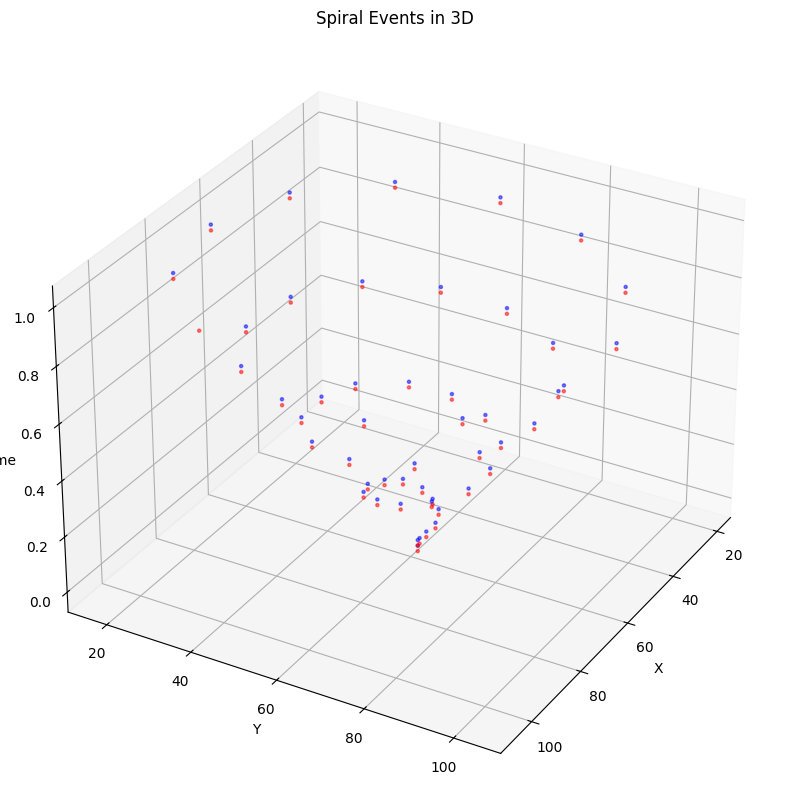

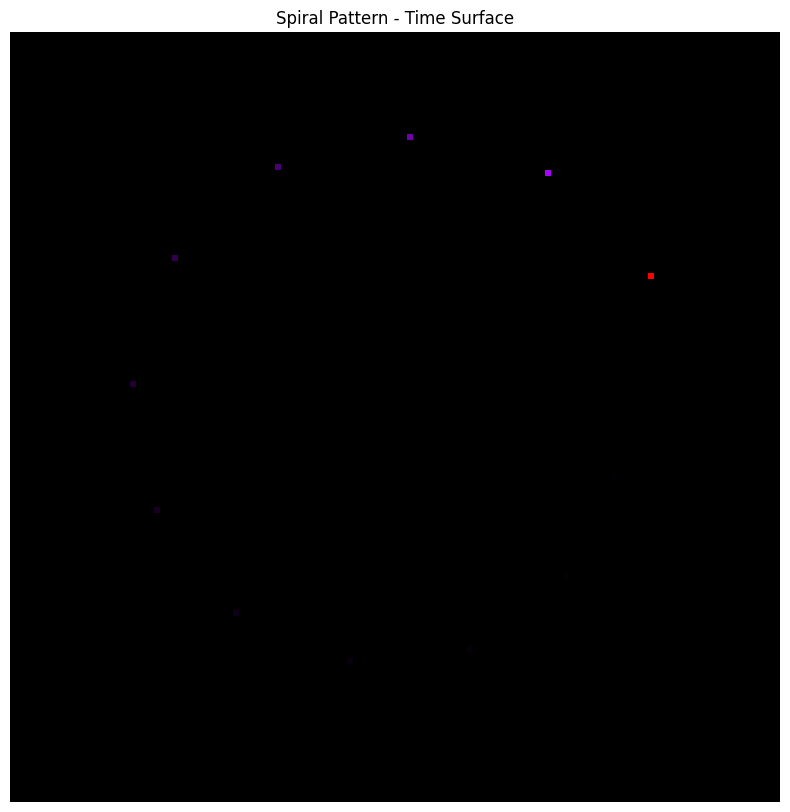

In [10]:
def generate_spiral_events(width=128, height=128, num_frames=50, max_radius=50):
    """Generate events in a spiral pattern"""
    events = []
    timestamps = np.linspace(0, 1, num_frames)
    center_x, center_y = width // 2, height // 2
    
    for i, t in enumerate(timestamps):
        # Increase radius linearly with time
        radius = max_radius * (i / num_frames)
        angle = i * 8 * np.pi / num_frames  # Multiple rotations
        
        # Compute position
        x = int(center_x + radius * np.cos(angle))
        y = int(center_y + radius * np.sin(angle))
        
        if 0 <= x < width and 0 <= y < height:
            # Add current point with positive polarity
            events.append((x, y, t, 1))
            
            # Add negative polarity events at previous positions
            if i > 0:
                prev_radius = max_radius * ((i-1) / num_frames)
                prev_angle = (i-1) * 8 * np.pi / num_frames
                prev_x = int(center_x + prev_radius * np.cos(prev_angle))
                prev_y = int(center_y + prev_radius * np.sin(prev_angle))
                
                if 0 <= prev_x < width and 0 <= prev_y < height:
                    events.append((prev_x, prev_y, t, -1))
    
    # Convert to numpy arrays
    xs = np.array([e[0] for e in events], dtype=np.int64)
    ys = np.array([e[1] for e in events], dtype=np.int64)
    ts = np.array([e[2] for e in events], dtype=np.float64)
    ps = np.array([e[3] for e in events], dtype=np.int64)
    
    return xs, ys, ts, ps

# Generate spiral events
spiral_xs, spiral_ys, spiral_ts, spiral_ps = generate_spiral_events(width, height)
print(f"Generated {len(spiral_xs)} events for spiral pattern")

# Visualize in 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
plot_events_3d(spiral_xs, spiral_ys, spiral_ts, spiral_ps, "Spiral Events in 3D", ax, azim=30, elev=30)
plt.show()

# Create time surface
spiral_ts_surface = create_time_surface(spiral_xs, spiral_ys, spiral_ts, spiral_ps, width, height)
plt.figure(figsize=(10, 10))
plt.imshow(spiral_ts_surface)
plt.title("Spiral Pattern - Time Surface")
plt.axis('off')
plt.show()

## 10. Event Representation Comparison

Finally, let's compare different event representations side by side:

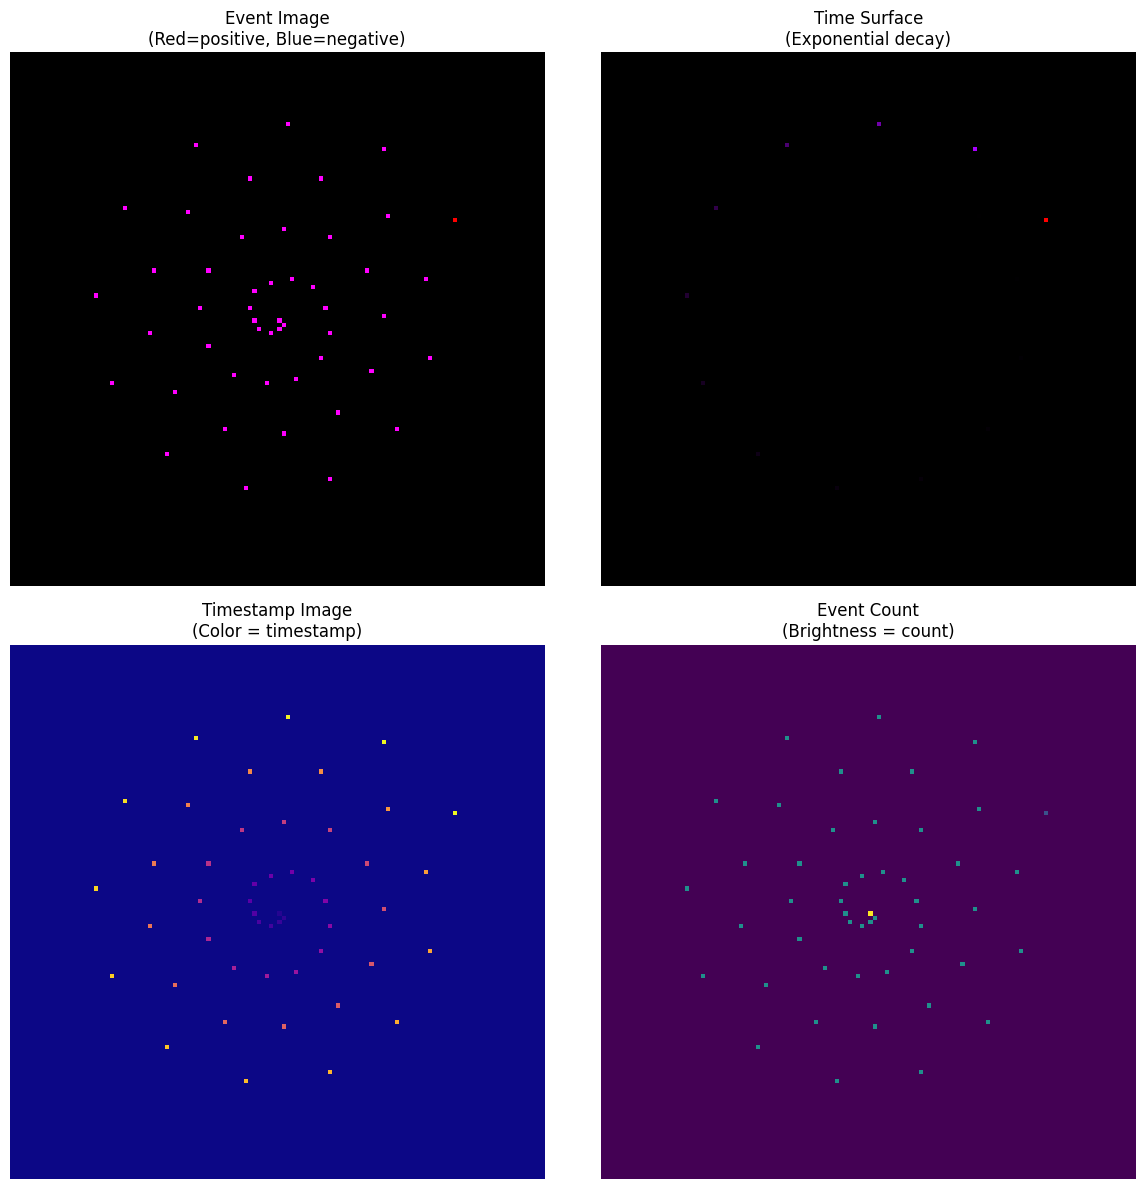

In [11]:
def create_event_image(xs, ys, ps, width, height):
    """Create a simple event image, red for positive, blue for negative"""
    img = np.zeros((height, width, 3))
    
    for x, y, p in zip(xs, ys, ps):
        if 0 <= x < width and 0 <= y < height:
            if p > 0:
                img[y, x, 0] = 1.0  # Red for positive
            else:
                img[y, x, 2] = 1.0  # Blue for negative
    
    return img

def create_timestamp_image(xs, ys, ts, width, height):
    """Create an image where pixel intensity is based on timestamp"""
    img = np.zeros((height, width))
    t_min, t_max = ts.min(), ts.max()
    t_range = t_max - t_min if t_max > t_min else 1.0
    
    for x, y, t in zip(xs, ys, ts):
        if 0 <= x < width and 0 <= y < height:
            # Normalize timestamp to [0, 1]
            img[y, x] = (t - t_min) / t_range
    
    return img

def compare_representations(xs, ys, ts, ps, width, height):
    """Compare different event representations"""
    # Create representations
    event_img = create_event_image(xs, ys, ps, width, height)
    time_surface = create_time_surface(xs, ys, ts, ps, width, height)
    timestamp_img = create_timestamp_image(xs, ys, ts, width, height)
    
    # Event counts per pixel (event histogram)
    event_count_img = np.zeros((height, width))
    for x, y in zip(xs, ys):
        if 0 <= x < width and 0 <= y < height:
            event_count_img[y, x] += 1
    
    # Normalize event count
    event_count_max = event_count_img.max()
    if event_count_max > 0:
        event_count_img = event_count_img / event_count_max
    
    # Visualize
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    
    axes[0, 0].imshow(event_img)
    axes[0, 0].set_title("Event Image\n(Red=positive, Blue=negative)")
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(time_surface)
    axes[0, 1].set_title("Time Surface\n(Exponential decay)")
    axes[0, 1].axis('off')
    
    axes[1, 0].imshow(timestamp_img, cmap='plasma')
    axes[1, 0].set_title("Timestamp Image\n(Color = timestamp)")
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(event_count_img, cmap='viridis')
    axes[1, 1].set_title("Event Count\n(Brightness = count)")
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    return fig

# Compare representations for spiral events
compare_representations(spiral_xs, spiral_ys, spiral_ts, spiral_ps, width, height)
plt.show()

## Conclusion

This notebook demonstrates various techniques for visualizing event camera data using the `evlib` library. Event cameras capture sparse, asynchronous data that can be challenging to visualize, but the techniques shown here provide different perspectives on the data.

Key visualization approaches include:
1. 2D scatterplots with polarity as color
2. 3D spatiotemporal plots
3. Time surfaces with exponential decay
4. Event slices for temporal evolution
5. Frame-based accumulations
6. Various event representations (timestamp images, event counts, etc.)

The notebook also demonstrates event generation, transformation, and augmentation capabilities of evlib.